# Ensemble tree models

Last week we saw how ensembling models can lead to better results than a single model. We did this by hand by creating three different models and having them "vote" on the result. Ensembled models are some of the most powerful models out there, and regularly win [Kaggle competitions](https://www.kaggle.com/competitions). This week we will discuss some models which themselves are ensembles, meaning the model is actually a collection of many different models. 

## Imports

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from xgboost.sklearn import XGBClassifier

## Data loading

This week we'll continue working with the flight delay prediction dataset. That way we can compare the results we get from these ensemble models to the results from simple models and "hand-ensembled" models. We'll load the saved cleaned data from last wek.

In [ ]:
df = pd.read_csv('data/flights_jan_2019_cleaned.csv')

In [ ]:
df.head()

,day_of_month,day_of_week,airline,origin,dest,dep_del15,arr_del15,cancelled,diverted,distance,dep_hour,arr_hour
0,1,2,20363,128,19,0.0,0.0,0.0,0.0,300.0,6.016667,7.366667
1,1,2,20363,225,80,0.0,0.0,0.0,0.0,596.0,13.983333,16.550000
2,1,2,20363,95,80,0.0,0.0,0.0,0.0,229.0,12.250000,13.483333
3,1,2,20363,325,19,0.0,0.0,0.0,0.0,223.0,15.350000,16.416667
4,1,2,20363,19,120,0.0,0.0,0.0,0.0,579.0,18.783333,19.666667


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.3)

X_cols = ['day_of_month', 'day_of_week', 'airline', 'origin', 'dest', 'dep_del15', 'cancelled', 'diverted', 'dep_hour', 'arr_hour']
y_col = 'arr_del15'

X_train = train_df[X_cols]
y_train = train_df[y_col]

X_test = test_df[X_cols]
y_test = test_df[y_col]

## Why ensemble? <a id="why_ensemble"></a>

We saw last week that ensembling can lead to better results, but why? What is about combining models that causes the results to be better? After all, how do we know they won't come to a census on the *wrong* prediction?

The general idea is what is called "bias-variance tradeoff". In machine learning, no model will make perfect predictions (at least for any realistic case). The error it makes can be broken down into three components:

**Error = Bias + Variance + Noise**

**Bias** means the way in which your models predictions are influenced by the model chosen. For instance, linear regression will always predict a line. Therefore, if your data is not a perfect line, linear regression will always have error when attempting to predict it. Since this error is due to the assumptions of your model (and how they don't perfectly match your match), we call this "bias". You can think of it as being analogous to how humans have bias. We are biased in certain directions largely based on our life experiences. You may be biased against smoking because you grew up hearing smoking was bad, and maybe saw a family member who died early from smoking. However, if you took someone who had no such experience, they may not be biased against smokers. 

**Variance** means how much the predictions change based on the input to the model. For instance, suppose you wanted to model the salary of a person based on their education. If you took one hundred random people and trained your model with them you would get a certain result. But what about if you changed your data and picked 100 new people. Since their educations are likely different, your model would be different. If your model could change drastically (such as how linear regression does with outliers) then we would say it has high variance.

**Noise** simply means noise in the data. Essentially no data follows any perfect pattern, and even the best model will still have slight errors, simply because of this. Noise is unavoidable in the data.

Bias and variance can also change with changing the hyperparameters of a model. For instance, suppose you had a decision tree with a maximum depth of 3. This is a simple model which can only make $2^3$ decision (each leaf splits into two leaves three times). Therefore, it's not going to fit most data perfectly due to this rigid structure, and thus it has high bias. However, because there are so few decisions being made, changing the data slightly isn't going to drastically alter the results, and thus the variance is low. However, if we change it to have depth 200, then the exact opposite is true. It now can fit the data extremely well due to having so many decision rules. However, all these rules mean even small changes to the data can result in big prediction changes, and thus the variance is high.

**Rule of thumb:** The more complex and nuanced a model is, the higher the bias and the lower the variance. The simpler a model is, the higher the variance and the lower the bias.

When we ensemble models we are attempting to reduce bias and/or variance. For example, if you ensemble a linear model, a decision tree and a nearest neighbors model, these all have different structures. Therefore, even if our data was not linear (and thus couldn't be fit well by the linear regression model), it may still be fit well by the other models. Therefore, by ensembling we would be effectively reducing the bias. Similarly, if we have a high variance model like a deep decision tree, we can reduce the variance by ensembling it with a simpler, lower variance model.

## Random forests <a id="random_forests"></a>

The first ensemble model we'll learn is called random forests. Random forests are simply a collection of decision trees, each fitted on slightly different data, and then taken together to average their predictions. For a regression problem this means the prediction is literally the average of the predicted values. For a classification problem the probabilities predicted are averaged, and a class is chosen based on the resulting average probability. Regardless, the point is to address the problem discussed above: simple decision trees are too simple to fit the data well, but complex trees are too deep to produce reliable predictions. By averaging many deep trees we hope that the mistakes will "cancel each other out." Let's jump right into building random forests. Note that at the top of this notebook we imported `RandomForestClassifier` from `sklearn.ensemble`. There is also a `RandomForestRegressor` for regression problems.

Random forests have almost all of the same hyperparameters as decision trees...because they are decision trees, just lots of them! So the main difference is choosing how many decision trees should be made, which is the parameter `n_estimators`. This is another hyperparameter, and thus should be determined using grid search and cross validation like we did last week. The default value in sklearn is 100, which shows you just how many trees are considered a "default". In addition, you have the option to have each tree only work with a subset of the columns. This is controlled by `max_features`, which tells it how many columns it should use. The point of all of this randomness (random selection of columns, 100 different tree, random selection of rows) is to create trees which come to different conclusions. Then we can take those conclusions and look at them "on average" to make a final prediction.

Random forests are slow to train because they involve building many trees. Therefore, we will just train a single one with guesses at the hyperparameters.

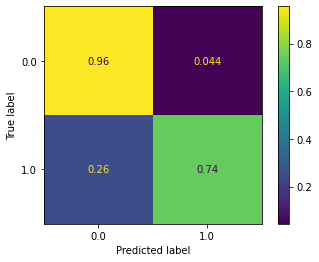

In [ ]:
rf_clf = RandomForestClassifier(min_samples_split=25, max_depth=100, min_samples_leaf=25, max_features=3, n_estimators=100, n_jobs=-1)

rf_clf.fit(X_train, y_train)

plot_confusion_matrix(rf_clf, X_test, y_test, normalize='true')

What an improvement over last week! If you recall, last week we also had 95%+ accuracy on non-delayed flights, but we struggled greaty on flights that were delayed. However, this new random forest model does very well on both classes. Getting 75% accuracy on delayed flights is fantastic, and could likely be improved further through hyperparameter tuning.

## Gradient boosting <a id="gradient_boosting"></a>

Gradient boosting is another form of ensembling, however we talk about gradient boosting on its own for two reasons. The first is that it works in a fundamentally different way than random forests. While random forests randomly creates trees and hopes that in combination they will make good predictions, **gradient boosting** constructs trees by learning from the mistakes of previous trees (we go more into this below). The second reason is that implementations of gradient boosting in Python (the most famous being [XGBoost](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)) have won numerous data science competitions. If you have tabular data (meaning data best represented by tables, including all datasets we have seen in this class, but *not* things like images, audio or long text) and want to perform classification or regression, gradient boosting is likely the state of the art. If you are building a serious prediction model to work with complex data, it would be expected that you have tried using a gradient boosting model. Failure to do so would be leaving your most powerful tool in the toolbox.

### Mathematics of gradient boosting <a id="math_boosting"></a>

Let's start by discussing the mathematics of gradient boosting, as without an understanding of the underlying mechanics you can never truly understand why it matters and how it works.

In general, gradient boosting follows these steps:
1. Start with an initial tree model
2. Find where the existing model makes incorrect predictions
3. Create a new tree which "fixes" those incorrect predictions as best as possible
4. Set the new model to be the existing tree plus this newly created one
5. Repeat steps 2 through 4 as many times as you like.

Let's go into each of these steps in detail.

**1. Start with an initial tree model**:
This is exactly what it sounds like. Our initial tree is just a decision tree like we have already seen.

**2. Find where the existing model makes incorrect predictions**:
Recall that we measure how well our model is doing by a *loss function*. We have often used mean squared error (MSE) as the loss function for regression problems, and cross entropy as the loss function for classification problems. The loss function returns a large value if the predictions are way off, and a small value if the predictions are close to being correct.

Let's play a game. Suppose you have the following points and want to fit a decision tree to them:

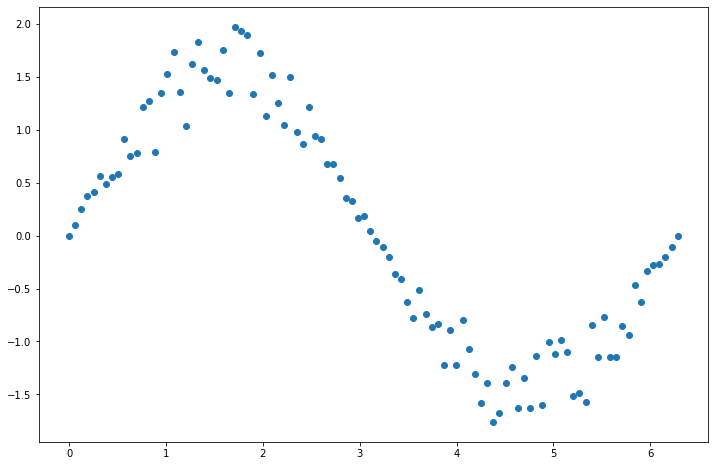

In [ ]:
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)*(1+np.random.rand(100))

plt.figure(figsize=(12, 8))
plt.scatter(x, y)

Let's fit a decision tree.

In [ ]:
dt_reg_1 = DecisionTreeRegressor(max_depth=3)

dt_reg_1.fit(x.reshape(100, 1), y) # Try removing the reshape and see what the error tells you

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
y_pred_1 = dt_reg_1.predict(x.reshape(100, 1))

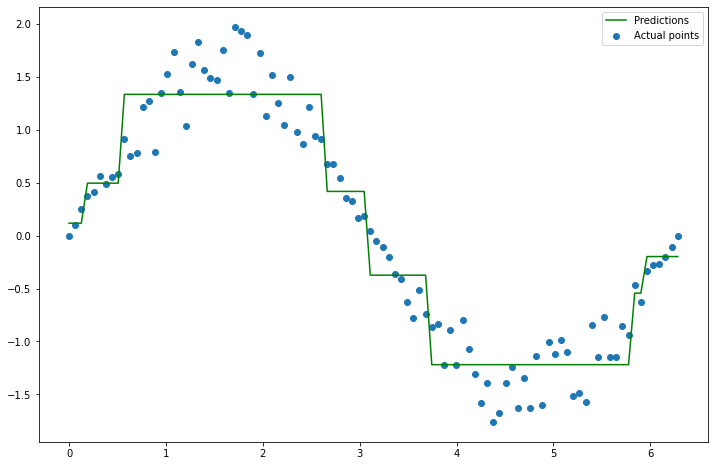

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(x, y, label='Actual points')
plt.plot(x, y_pred_1, label='Predictions', color='green')
plt.legend();

Clearly, these predictions aren't perfect. So, you hand your decision tree and all the points to your neighbor. Their job is now to build a new decision tree *which will be added to your tree* to make the model better. So if your decision tree is $f_1(x)$, then they need to come up with a tree $f_2(x)$ so that $f_1(x) + f_2(x)$ fits the data better than just $f_1(x)$ alone. How can they do this? Well, they can build a tree based on where your model made mistakes. For instance, your model is wrong whenever $f_1(x) \neq y$, or equivalently, where $y - f_1(x) \neq 0$. So let's fit a new tree to $y - f_1(x)$, and call that $f_2(x)$. Why is this an improvement? Because taking $f_2(x) \approx y - f_1(x)$, and thus $f_1(x) + f_2(x) \approx y$. Let's try it.

In [ ]:
# y - f_1(x), since f_1(x) is the predictions from the first model
y_residual_2 = y - y_pred_1

# fit a new tree to y - f_1(x)
dt_reg_2 = DecisionTreeRegressor(max_depth=3)
dt_reg_2.fit(x.reshape(100, 1), y_residual_2)

# Make predictions again
y_pred_2 = dt_reg_2.predict(x.reshape(100, 1))

# Set my new predictions (i.e. model) to be the old predictions plus the new ones
new_preds_2 = y_pred_1 + y_pred_2

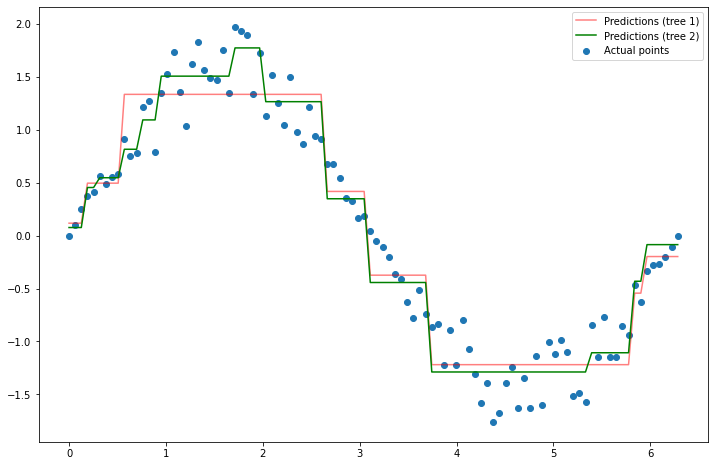

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(x, y, label='Actual points')
plt.plot(x, y_pred_1, label='Predictions (tree 1)', color='red', alpha=0.5)
plt.plot(x, new_preds_2, label='Predictions (tree 2)', color='green')
plt.legend();

An improvement! Let's do it once more.

In [ ]:
# y - f_1(x), since f_1(x) is the predictions from the first model
y_residual_3 = y - new_preds_2

# fit a new tree to y - f_1(x)
dt_reg_3 = DecisionTreeRegressor(max_depth=3)
dt_reg_3.fit(x.reshape(100, 1), y_residual_3)

# Make predictions again
y_pred_3 = dt_reg_3.predict(x.reshape(100, 1))

# Set my new predictions (i.e. model) to be the old predictions plus the new ones
new_preds_3 = y_pred_1 + y_pred_2 + y_pred_3

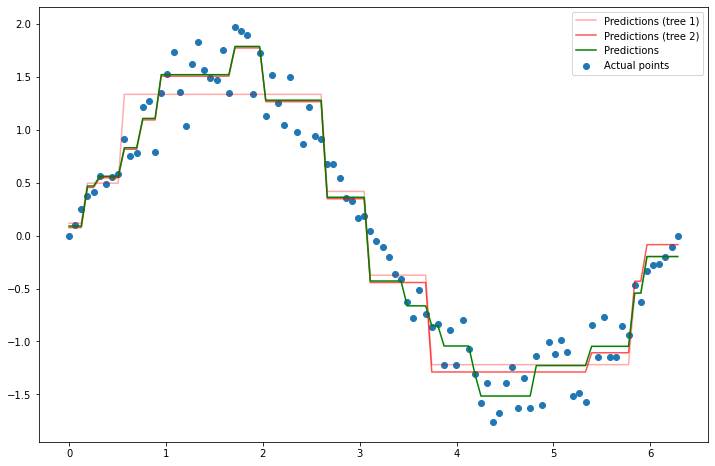

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(x, y, label='Actual points')
plt.plot(x, y_pred_1, label='Predictions (tree 1)', color='red', alpha=0.33)
plt.plot(x, new_preds_2, label='Predictions (tree 2)', color='red', alpha=0.67)
plt.plot(x, new_preds_3, label='Predictions', color='green')
plt.legend();

Let's plot the predictions from just the first tree, along with the predictions from these three trees added together to make it clear how our model hsa changed.

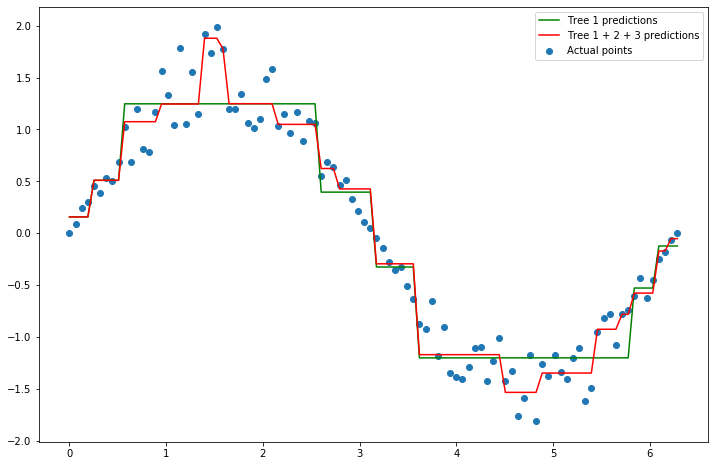

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(x, y, label='Actual points')
plt.plot(x, y_pred_1, label='Tree 1 predictions', color='green')
plt.plot(x, new_preds, label='Tree 1 + 2 + 3 predictions', color='red')
plt.legend()

We can see that the combined trees make a more detailed model. This is precisely the process that gradient boosting takes.

## XGBoost <a id="xgboost"></a>

There are several different implementations of gradient boosting, each with their own nuances. However, by far the most popular is XGBoost. We will continue with predicting flight delays, but this time using XGBoost. 

While XGBoost is powerful, it has [many, many different hyperparameters](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn). Unless you are willing to let your model run for very, very long, it is infeasible to tune all of them using grid search cross validation. Therefore, we will typically restrict ourselves to just a few:
- **n_estimators:** The same as for random forest. It's how many trees to build.
- **max_depth:** How deep each tree should be built.
- **learning_rate:** Gradient descent determines how much it should change each tree by using a learning rate. A large leraning rate (a value near 1) means it may make too big of jumps. A smaller value (0.0001 or smaller, for example) may make it learn too slowly.

These are a great starting point for hyperparameter tuning. However, if you are trying to really improve your model, it is worth your time to learn about other hyperparameters and tune those as well.

Using XGBoost is just the same as anything else in sklearn, we instantiate it with our hyperparameters, fit it, and make predictions with it. However, note that it is *not* included in sklearn. We had to import it instead from `xgboost.sklearn`. Due to grid search taking so long, we will just train one model with guesses at the hyperparameters.

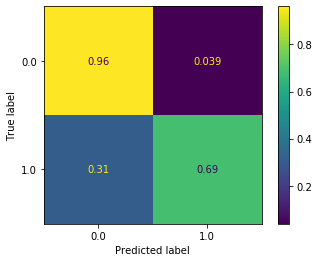

In [ ]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=100, learning_rate=1e-3, n_jobs=-1)

xgb_clf.fit(X_train, y_train)

plot_confusion_matrix(xgb_clf, X_test, y_test, normalize='true')

Not bad! We maintain our very good accuracy on non-delayed flights, and bump up our accuracy on delayed flights to 69%. This is a big improvement over anything we got last week. However, it's actually still not as good as the random forest model we trained above. Ensemble models are highly influenced by hyperparameter choices. Therefore it's very possible that both models could be improved significantly through hyperparameter tuning.

## Feature engineering <a id="feature_engineering"></a>

Along with ensembling, feature engineering is one of the most important techniques in designing highly effective machine learning models. By **feature engineering** we mean creating new columns (features) by modifying the original data. This can take many forms. We will explore this using the LA Marathon dataset.

In [ ]:
df = pd.read_csv(drive_dir + 'data/2016_la_marathon.csv')

In [ ]:
df.head()

,div_place,name,bib,age,place,gender_place,5k_split,10k_split,15k_split,20k_split,25k_split,30k_split,35k_split,40k_split,clock_time,net_time,hometown
0,1,SAUL VISCARRA,40402,15,382,352,22:28,44:00,1:04:56,1:26:24,1:48:24,2:11:32,2:37:42,3:01:56,3:22:41,3:11:51,NaN
1,2,FERNANDO GOMEZ,40504,15,560,504,22:37,45:17,1:07:50,1:31:42,1:55:46,2:19:58,2:44:35,3:09:32,3:23:09,3:18:54,NaN
2,3,MARCOS GONZALEZ,40882,15,1042,881,24:08,47:44,1:10:34,1:34:10,1:58:40,2:23:37,2:54:01,3:23:20,3:43:35,3:31:59,NaN
3,4,LUIS MORALES,42286,13,1294,1076,22:50,46:21,1:11:07,1:34:42,1:58:49,2:24:17,2:54:27,3:26:22,3:41:55,3:37:24,NaN
4,5,PETER CASTANO,20099,15,1413,1166,26:13,53:12,1:19:36,1:45:47,2:11:53,2:38:18,3:03:38,3:29:46,3:45:48,3:39:31,NaN


We will attempt to build a model to predict the overall place the person got (in the `place` column). Let's quickly do some cleaning. The most important thing is to change the times so that they're actual numbers (right now they're strings). We'll convert each one to minutes, so that it shows how many minutes it took them to get to 5k, 10k, etc. We'll do this by writing a custom function to parse the time, and using the Pandas `.apply()` function to apply the function to every row.

In [ ]:
def split_to_min(split_str):
    # Some data has problems and can't be converted to numbers. So if that happens we'll note it and move on.
    try:
        split_list = split_str.split(':')
        # Depending on how fast/slow the person it, their split could just be of the form mm:ss (minutes:seconds), or it
        # could involve hours, like hh:mm:ss. We'll check how many things appeared when splitting to find out.
        if len(split_list) == 2: # Only mm:ss
            minutes, seconds = split_list
            hours = 0
        else: # Must have all three
            hours, minutes, seconds = split_list
        # We'll convert everything to minutes. 
        hours = int(hours) * 60
        minutes = int(minutes)
        seconds = int(seconds) / 60
        split_min = hours + minutes + seconds
        return split_min
    except Exception as e:
        return None

In [ ]:
split_cols = [f'{n}k_split' for n in range(5, 45, 5)] + ['clock_time', 'net_time']

In [ ]:
split_cols

['5k_split',
 '10k_split',
 '15k_split',
 '20k_split',
 '25k_split',
 '30k_split',
 '35k_split',
 '40k_split',
 'clock_time',
 'net_time']

In [ ]:
for col in split_cols:
    df[col] = df[col].apply(split_to_min)

In [ ]:
df.head()

,div_place,name,bib,age,place,gender_place,5k_split,10k_split,15k_split,20k_split,25k_split,30k_split,35k_split,40k_split,clock_time,net_time,hometown
0,1,SAUL VISCARRA,40402,15,382,352,22.466667,44.000000,64.933333,86.400000,108.400000,131.533333,157.700000,181.933333,202.683333,191.850000,NaN
1,2,FERNANDO GOMEZ,40504,15,560,504,22.616667,45.283333,67.833333,91.700000,115.766667,139.966667,164.583333,189.533333,203.150000,198.900000,NaN
2,3,MARCOS GONZALEZ,40882,15,1042,881,24.133333,47.733333,70.566667,94.166667,118.666667,143.616667,174.016667,203.333333,223.583333,211.983333,NaN
3,4,LUIS MORALES,42286,13,1294,1076,22.833333,46.350000,71.116667,94.700000,118.816667,144.283333,174.450000,206.366667,221.916667,217.400000,NaN
4,5,PETER CASTANO,20099,15,1413,1166,26.216667,53.200000,79.600000,105.783333,131.883333,158.300000,183.633333,209.766667,225.800000,219.516667,NaN


In [ ]:
df.isna().sum()

div_place           0
name                0
bib                 0
age                 0
place               0
gender_place        0
5k_split          825
10k_split         162
15k_split         101
20k_split          91
25k_split          73
30k_split         140
35k_split          95
40k_split         161
clock_time          1
net_time            0
hometown        11499
dtype: int64

Let's just drop missing values for anything except `hometown`, which we don't really care about anyway. We'll also drop their name and their place in their division, along with their place in their gender (since knowing what place they got in their division/gender is perhaps "cheating"). Finally, if we know how long it took them to get to the 40k mark (which is just two kilometers short of the finish line) then we could obviously predict their place, since they've almost finished the race! So we'll only keep the first half (20km).

In [ ]:
df = df.drop(['hometown', 'name', 'div_place', 'gender_place', '25k_split', '30k_split', '35k_split', '40k_split', 'clock_time', 'net_time'], axis='columns')
df = df.dropna(how='any')

In [ ]:
df.head()

,bib,age,place,5k_split,10k_split,15k_split,20k_split
0,40402,15,382,22.466667,44.000000,64.933333,86.400000
1,40504,15,560,22.616667,45.283333,67.833333,91.700000
2,40882,15,1042,24.133333,47.733333,70.566667,94.166667
3,42286,13,1294,22.833333,46.350000,71.116667,94.700000
4,20099,15,1413,26.216667,53.200000,79.600000,105.783333


In [ ]:
df.dtypes

bib            int64
age            int64
place          int64
5k_split     float64
10k_split    float64
15k_split    float64
20k_split    float64
dtype: object

Everything looks good, let's get started.

A good idea is to first train a model on the original data *before* you start doing feature engineering. We saw that the more advanced ensemble models have results that vary greatly depending on the hyperparameters chosen. Since it is very slow to do a grid search and find these hyperparameters, we'll just use a plain decision tree as our baseline model. Once we think we've engineering some features that seem useful (based on the results of the decision tree), we can then try a more advanced model.

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.3)
X_cols = ['bib', 'age', '5k_split', '10k_split', '15k_split', '20k_split']
y_col = 'place'

X_train = train_df[X_cols]
y_train = train_df[y_col]

X_test = test_df[X_cols]
y_test = test_df[y_col]

In [ ]:
dt_baseline = DecisionTreeRegressor(max_depth=20, min_samples_split=20, min_samples_leaf=50)

dt_baseline.fit(X_train, y_train)

print(f'R^2 = {dt_baseline.score(X_test, y_test)**2:.4f}')

R^2 = 0.8327


Not a bad R^2 value! Let's try to beat it by engineering some new features.

Feature engineering typically follows two steps:
1. Think about what features your data doesn't yet have, and which might be useful.
2. Create those features, train a new model with them, and see if things improve.

This process is then repeated over and over.

Let's start with thinking about how runners speed changes throughout the race. Presumably, most runners start fast and then slow down as they get tired. But what about the elite runners? Do they do this as well? We'll start by comparing their time to complete the first 5k, versus how long it took them to go from 15k to 20k. We'll then create a new column which is whether how much faster/slower this was than their first 5k.

In [ ]:
df['last_5k_minus_first_5k'] = (df['20k_split'] - df['15k_split']) - df['5k_split']

In [ ]:
df.head()

,bib,age,place,5k_split,10k_split,15k_split,20k_split,last_5k_minus_first_5k
0,40402,15,382,22.466667,44.000000,64.933333,86.400000,-1.000000
1,40504,15,560,22.616667,45.283333,67.833333,91.700000,1.250000
2,40882,15,1042,24.133333,47.733333,70.566667,94.166667,-0.533333
3,42286,13,1294,22.833333,46.350000,71.116667,94.700000,0.750000
4,20099,15,1413,26.216667,53.200000,79.600000,105.783333,-0.033333


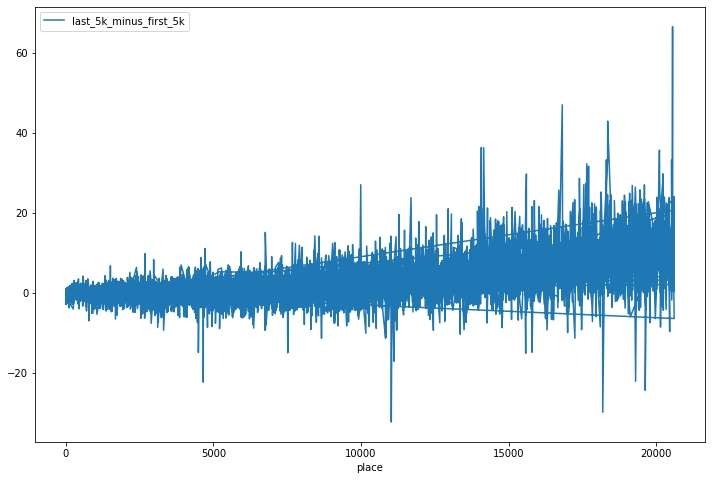

In [ ]:
df.plot(x='place', y='last_5k_minus_first_5k', figsize=(12, 8))

So it looks like there is indeed a general positive trend, where people who did very well (low placing) had `first_5k_vs_last_5k` being close to 0, and people who finished lower had a positive value (a positive value means their last 5k was slower than their first 5k). Before we go any further, let's just train a model by including this new column and seeing how our results change. Note that our training and testing dataframes don't have this new column (we just created them on the original data). So let's create it there first.

In [ ]:
def last_5k_minus_first_5k_col(df):
    df['last_5k_minus_first_5k'] = (df['20k_split'] - df['15k_split']) - df['5k_split']

In [ ]:
last_5k_minus_first_5k_col(X_train)
last_5k_minus_first_5k_col(X_test)

<ipython-input-276-37485025437d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['last_5k_minus_first_5k'] = (df['20k_split'] - df['15k_split']) - df['5k_split']


In [ ]:
dt_fe1 = DecisionTreeRegressor(max_depth=20, min_samples_split=20, min_samples_leaf=50)

dt_fe1.fit(X_train, y_train)

print(f'R^2 = {dt_fe1.score(X_test, y_test)**2:.4f}')

R^2 = 0.8405


A slight improvement! We did this for the first versus last 5k. But what about if we created new columns which showed how their current 5k time compared to their previous 5k time.

In [ ]:
def this_5k_minus_prev_5k_col(df):
    df['10k_vs_5k'] = (df['10k_split'] - df['5k_split']) - df['5k_split']
    df['15k_vs_10k'] = (df['15k_split'] - df['10k_split']) - (df['10k_split'] - df['5k_split'])
    df['20k_vs_15k'] = (df['20k_split'] - df['15k_split']) - (df['15k_split'] - df['10k_split'])

In [ ]:
this_5k_minus_prev_5k_col(X_train)
this_5k_minus_prev_5k_col(X_test)

In [ ]:
dt_fe2 = DecisionTreeRegressor(max_depth=20, min_samples_split=20, min_samples_leaf=50)

dt_fe2.fit(X_train, y_train)

print(f'R^2 = {dt_fe2.score(X_test, y_test)**2:.4f}')

R^2 = 0.8406


A very, very slight improvement. One potential reason for this is simply that our model has more columns to consider, but we're not allowing the tree to be any more complex (deeper, for instance). Perhaps if we increased the depth our score might improve. Let's try it.

In [ ]:
dt_fe2_deeper = DecisionTreeRegressor(max_depth=50, min_samples_split=20, min_samples_leaf=50)

dt_fe2_deeper.fit(X_train, y_train)

print(f'R^2 = {dt_fe2_deeper.score(X_test, y_test)**2:.4f}')

R^2 = 0.8406


Nope, that didn't help. So maybe those extra columns are actually not that useful. Let's get rid of them so that we don't include columns which aren't contributing much.

In [ ]:
X_train.head()

,bib,age,5k_split,10k_split,15k_split,20k_split,last_5k_minus_first_5k,10k_vs_5k,15k_vs_10k,20k_vs_15k
11206,3168,67,27.183333,55.500000,83.133333,110.450000,0.133333,1.133333,-0.683333,-3.166667e-01
6798,22198,41,25.283333,50.166667,74.283333,98.916667,-0.650000,-0.400000,-0.766667,5.166667e-01
9190,23994,49,50.766667,97.916667,142.316667,189.216667,-3.866667,-3.616667,-2.750000,2.500000e+00
2501,11962,29,25.200000,49.683333,73.000000,96.316667,-1.883333,-0.716667,-1.166667,-7.105427e-15
4289,6146,31,25.766667,52.266667,78.616667,105.183333,0.800000,0.733333,-0.150000,2.166667e-01


In [ ]:
X_train = X_train.drop(['10k_vs_5k', '15k_vs_10k', '20k_vs_15k'], axis='columns')
X_test = X_test.drop(['10k_vs_5k', '15k_vs_10k', '20k_vs_15k'], axis='columns')

In [ ]:
X_train.head()

,bib,age,5k_split,10k_split,15k_split,20k_split,last_5k_minus_first_5k
11206,3168,67,27.183333,55.500000,83.133333,110.450000,0.133333
6798,22198,41,25.283333,50.166667,74.283333,98.916667,-0.650000
9190,23994,49,50.766667,97.916667,142.316667,189.216667,-3.866667
2501,11962,29,25.200000,49.683333,73.000000,96.316667,-1.883333
4289,6146,31,25.766667,52.266667,78.616667,105.183333,0.800000


What about comparing each runner's time to the average time to that mark? So for instance, if the average runner takes 40 minutes to get to the 5k mark, how much slower or faster is each runner? In fact, there's no reason to do this for just time, we can also do it for age and bib number. Let's see if those new features are useful.

In [ ]:
def value_vs_mean(df):
    for col in df.columns:
        new_col_name = f'{col}_vs_mean'
        df[new_col_name] = df[col] - df[col].mean()

In [ ]:
value_vs_mean(X_train)
value_vs_mean(X_test)

In [ ]:
dt_fe3 = DecisionTreeRegressor(max_depth=20, min_samples_split=20, min_samples_leaf=50)

dt_fe3.fit(X_train, y_train)

print(f'R^2 = {dt_fe3.score(X_test, y_test)**2:.4f}')

R^2 = 0.8411


Again, a slight improvement. 

When you start adding more and more features, your models need to be more and more complex to handle them properly. Therefore, it is to your advantage to only include features which are actually improving the model. How can you determine this? One way would be to add columns one at a time and see how things change. However, this is highly time consuming. Another more efficient way is to ask the model to tell you! Most models keep track of "feature importances", which are measure the model uses to determine how useful a feature is. For a tree, this is stored in the `.feature_importances_` attribute.

In [ ]:
dt_fe3.feature_importances_

array([7.25661052e-04, 6.41068604e-04, 7.38459485e-05, 1.12079260e-03,
       9.84246838e-05, 8.28753967e-01, 2.20368148e-02, 4.78292268e-04,
       2.85487107e-04, 1.30575962e-03, 2.88408609e-04, 2.22836673e-04,
       1.31116001e-01, 1.28526395e-02])

This is returning the feature importance for each column. They are returned in the same order as the columns. So we can print this more nicely if we print the columns at the same time.

In [ ]:
for i in range(X_train.shape[1]):
    print(f'{X_train.columns[i]}: {dt_fe3.feature_importances_[i]:.4f}')

bib: 0.0007
age: 0.0006
5k_split: 0.0001
10k_split: 0.0011
15k_split: 0.0001
20k_split: 0.8288
last_5k_minus_first_5k: 0.0220
bib_vs_mean: 0.0005
age_vs_mean: 0.0003
5k_split_vs_mean: 0.0013
10k_split_vs_mean: 0.0003
15k_split_vs_mean: 0.0002
20k_split_vs_mean: 0.1311
last_5k_minus_first_5k_vs_mean: 0.0129


In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(X_train.columns, dt_fe3.feature_importances_)
plt.xticks(rotation=270)
plt.title('Feature importance');

NameError: name 'X_train' is not defined

<Figure size 864x576 with 0 Axes>

So  by far the most important columns are those related to the 20k mark. That makes sense, as it's the farthest into the race that we have info on. Interestingly enough, the only other column whose bar you can even see is `5k_split_vs_mean`, so that's useful as well. Let's try dropping all columns with a feature importance less than 0.001 and see where that leaves us.

In [ ]:
cols_to_keep = []
for i in range(X_train.shape[1]):
    if dt_fe3.feature_importances_[i] >= 0.001:
        cols_to_keep.append(X_train.columns[i])

In [ ]:
cols_to_keep

['10k_split',
 '20k_split',
 'last_5k_minus_first_5k',
 '5k_split_vs_mean',
 '20k_split_vs_mean',
 'last_5k_minus_first_5k_vs_mean']

In [ ]:
X_train = X_train[cols_to_keep]
X_test = X_test[cols_to_keep]

In [ ]:
dt_fe3_trimmed = DecisionTreeRegressor(max_depth=20, min_samples_split=20, min_samples_leaf=50)

dt_fe3_trimmed.fit(X_train, y_train)

print(f'R^2 = {dt_fe3_trimmed.score(X_test = X_test[cols_to_keep], y_test)**2:.4f}')

R^2 = 0.8429


It's actually a slight improvement! So getting rid of columns with low importance allowed our model to make better decisions with what was left.

Before we leave, let's briefly discuss the various forms feature engineering can take:
1. Combining information from multiple columns to make a new column (like we did above).
2. Simplifying a column. For example, rather than keeping their actual age, we could break it up into age groups of 5 years.
3. Bringing in new data and combining it with the existing data. For instance, we could look up the average running pace for runners of different ages, and make a column showing how much faster/slower each runner in the data is.
4. Summarizing data. A common example of this is dealing with text data. Models can't understand text data because it's not numbers. However, suppose you were trying to determine if an eBay listing was fraudulent. Perhaps fraudulent listings don't have as much information in them. So, if the data had a column "item description" which was text, you can try creating a column "item description length" which counted up how many characters were in the item description.

In general, feature engineering just requires you to be patient and creative. There's no magic formula that will yield you interesting and useful features, you just have to play around and try.